# Welcome to the OnSSET Notebook

This interface is built on the [OnSSET](http://www.onsset.org/) tool developed by KTH division of Energy Systems to provide an easy and quick way to generate electrification investment scenarios.

#### Start by importing the code 

In [2]:
from onsset import *
import os
import rasterio
from rasterio.features import rasterize
from skimage.graph.mcp import MCP_Geometric
from IPython.display import display, Markdown, HTML
import numba
%matplotlib inline
%load_ext line_profiler

# 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. 

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
#messagebox.showinfo('OnSSET', 'Open the input file with extracted GIS data')
#input_file = filedialog.askopenfilename()

input_file = r'C:\GitHub\many-to-many-dijkstra\burundi\bi-2-country-inputs.csv'

onsseter = SettlementProcessor(input_file)
onsseter.df['IsUrban'] = 0
onsseter.df['Conflict'] = 0
onsseter.df['PerCapitaDemand'] = 0

C:\Users\asahl\.conda\envs\gis\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis. Further down you will also define an intermediate year and target.

In [4]:
start_year = 2018
end_year = 2030
electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate 

#### Electricity demand target level
Next, enter the target tier (level of electricity access) for urban and rural households respectively. This can take a value between 1 (lowest level of electricity access) and 5 (highest level of electricity access) as in ESMAPs Multi-Tier Framework for Measuring Electricity Access (found <a href="https://www.esmap.org/node/55526" target="_blank">here</a>). 

In [5]:
urban_target_tier = 4
rural_target_tier = 3

#### Intermediate electrification rate target
The model is set up to run in two steps. Enter the intermediate target year and target electrification rate for that year.

In [6]:
intermediate_year = 2025
intermediate_electrification_target = 0.75 # E.g. for a target electrification rate of 75%, enter 0.75

#### PV system cost adjustment
This reflects the role of PV system costs on electrification results. All PV based systems will be adjusted by a factor to simulate a higher or lower cost of PV systems (compared to the baseline values entered below). A value lower than 1 means lower investment costs for PV systems compared to baseline, and a value larger than 1 means higher investment cost for PV systems compared to baseline. E.g. ***0.75*** would mean a cost that is 25% lower compared to baseline costs.

In [7]:
pv_adjustment_factor = 1

#### Grid specifications
This part can be used to impose restrictions or forced extensions of the grid. 

In [8]:
# Buffer distance (km) from the current grid network for automatic connection to the grid.
auto_intensification = 2

# This is the maximum amount of new households that can be connected to the grid in one year (thousands) per time-step
annual_new_grid_connections_limit = {intermediate_year: 146,
                                     end_year: 999999999}

# This is the maximum generation capacity that can be added to the grid in one year (MW)
annual_grid_cap_gen_limit = {intermediate_year: 287,
                             end_year: 999999999}

# 4. Enter country specific data

In addition to the options above the user can customize a large number of variables describing the social - economic - technological environment in the selected country. 

**Note!** Most input values shall represent estimates for the variable valid throughout the modelling period, i.e. **NOT** current values.

### a. Demographics and Social components

In [9]:
pop_start_year = 44271000       ### Write the population in the base year (e.g. 2018) 
end_year_pop = 63842360         ### Write the population in the end year of the analysis (e.g. 2030)

urban_ratio_start_year = 0.24   ### Write the urban population population ratio in the base year (e.g. 2018)
urban_ratio_end_year = 0.31     ### Write the urban population population ratio in the end year (e.g. 2030)

num_people_per_hh_urban = 4.0     ### Write the number of people per household expected in the end year (e.g. 2030)
num_people_per_hh_rural = 3.4   ### Write the number of people per household expected in the end year (e.g. 2030)

elec_ratio_start_year = 0.22   ### Write the electrification rate in the base year (e.g. 2018)
urban_elec_ratio = 0.577       ### Write urban electrification rate in the base year (e.g. 2018)
rural_elec_ratio = 0.11         ### Write rural electrification rate in the base year (e.g. 2018)

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be updated to reflect the most accurate values in the country. There are currently 7 potential technologies to include in the model:
* Grid
* PV Mini-grid
* Wind Mini-grid
* Hydro Mini-grid
* Diesel Mini-grid
* PV Stand-alone systems
* Diesel Stand-alone systems

First, decide whether to include diesel technologies or not:

In [10]:
diesel_techs = 0                      ### 0 = diesel NOT included, 1 = diesel included 

In [11]:
grid_generation_cost = 0.012           ### This is the grid electricity generation cost (USD/kWh) as expected in the end year of the analysis
grid_power_plants_capital_cost = 2300 ### The cost in USD/kW to for capacity upgrades of the grid
grid_losses = 0.082                     ### The fraction of electricity lost in transmission and distribution (percentage) 
base_to_peak = 0.8                    ### The ratio of base grid demand to peak demand (percentage) 
existing_grid_cost_ratio = 0.1        ### The additional cost per round of electrification (percentage) 

In [12]:
diesel_price = 0.5                   ### This is the diesel price in USD/liter as expected in the end year of the analysis.

In [13]:
sa_diesel_capital_cost = 938          ### Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_diesel_capital_cost = 721          ### Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_pv_capital_cost = 2950             ### Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis
mg_wind_capital_cost = 3750           ### Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis
mg_hydro_capital_cost = 3000          ### Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis

In [14]:
sa_pv_capital_cost_1 = 9620          ### Stand-alone PV capital cost (USD/kW) for household systems under 20 W
sa_pv_capital_cost_2 = 8780          ### Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W
sa_pv_capital_cost_3 = 6380           ### Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W
sa_pv_capital_cost_4 = 4470           ### Stand-alone PV capital cost (USD/kW) for household systems between 101-1000 W
sa_pv_capital_cost_5 = 6950           ### Stand-alone PV capital cost (USD/kW) for household systems over 1 kW

The cells below contain additional technology specifications

In [15]:
coordinate_units = 1000  # 1000 if coordinates are in m, 1 if coordinates are in km
discount_rate = 0.08 # E.g. 0.08 means a discount rate of 8%

# Transmission and distribution costs
hv_line_capacity=69 # kV
hv_line_cost=53000 # USD/km
mv_line_cost = 7000 # USD/kW
mv_line_capacity=33 # kV
mv_line_max_length=50 # km
mv_increase_rate=0.1
max_mv_line_dist = 50 # km
MV_line_amperage_limit = 8  # Ampere (A)
lv_line_capacity=0.24 #kV
lv_line_max_length=0.8 # km
lv_line_cost=4250 # USD/km
service_Transf_type=50  # kVa
service_Transf_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # maximum number of nodes served by each service transformer
hv_lv_transformer_cost=25000 # USD/unit
hv_mv_transformer_cost=25000 # USD/unit
mv_lv_transformer_cost=10000 # USD/unit
mv_mv_transformer_cost=10000 # USD/unit


# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.1,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=150,
                        base_to_peak_load_ratio=base_to_peak,
                        capacity_factor=1,
                        tech_life=30,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost={float("inf"): mg_hydro_capital_cost},
                            om_costs=0.02,
                            )

# Mini-grid wind costs
mg_wind_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capital_cost={float("inf"): mg_wind_capital_cost},
                            om_costs=0.02,
                            tech_life=20,
                            )

# Mini-grid PV costs
mg_pv_calc = Technology(om_of_td_lines=0.03,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.85,
                        tech_life=20,
                        om_costs=0.02,
                        capital_cost={float("inf"): mg_pv_capital_cost * pv_adjustment_factor}                        
                        )

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.02,
                        capital_cost={float("inf"): sa_pv_capital_cost_5 * pv_adjustment_factor,
                                      1: sa_pv_capital_cost_4 * pv_adjustment_factor,
                                      0.100: sa_pv_capital_cost_3 * pv_adjustment_factor,
                                      0.050: sa_pv_capital_cost_2 * pv_adjustment_factor,
                                      0.020: sa_pv_capital_cost_1 * pv_adjustment_factor},
                        standalone=True
                        )

# Mini-grid diesel costs
mg_diesel_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            capital_cost={float("inf"): mg_diesel_capital_cost},
                            mini_grid=True)



# Stand-alone diesel costs
sa_diesel_calc = Technology(base_to_peak_load_ratio=0.9,
                            capacity_factor=0.5,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost={float("inf"): sa_diesel_capital_cost},
                            standalone=True)

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year, discount_rate=discount_rate,
                             hv_line_type=hv_line_capacity, hv_line_cost=hv_line_cost, mv_line_type=mv_line_capacity,
                             mv_line_amperage_limit=MV_line_amperage_limit, mv_line_cost=mv_line_cost, lv_line_type=lv_line_capacity,
                             lv_line_cost=lv_line_cost, lv_line_max_length=lv_line_max_length, 
                             service_transf_type=service_Transf_type, service_transf_cost = service_Transf_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, mv_lv_sub_station_cost=mv_lv_transformer_cost,
                             mv_mv_sub_station_cost=mv_mv_transformer_cost, hv_lv_sub_station_cost=hv_lv_transformer_cost,
                             hv_mv_sub_station_cost=hv_mv_transformer_cost)

# 5. GIS data import and processing

OnSSET is a GIS based tool and its proper function depends heavily on the diligent preparation and calibration of the necessary geospatial data. Documentation on GIS processing in regards to OnSSET can be found <a href="http://onsset-manual.readthedocs.io/en/latest/data_acquisition.html" target="_blank">here</a>. The following cell reads the CSV-file containing the extracted GIS data for the country chosen in the previous section, and displays a snap-shot of some of the data.

In [16]:
yearsofanalysis = [end_year]

onsseter.condition_df()
onsseter.df[SET_GRID_PENALTY] = onsseter.grid_penalties(onsseter.df)
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs()
pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)
onsseter.project_pop_and_urban(end_year_pop, urban_ratio_end_year, start_year, yearsofanalysis)

eleclimits = {intermediate_year: intermediate_electrification_target, end_year: electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}
# ToDo
time_steps = {end_year: end_year-start_year}

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']].sample(7))


La population a été calibrée avec succès
Le ratio urbain modélisé est 0.24. Au cas où cela ne serait pas acceptable, veuillez réviser cette partie du code


#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
28788,Burundi,36.01551,0.0,0.21667,1835.00000,2.93416,239.712,44.40040
36795,Burundi,107.30816,0.0,0.41383,1915.17128,3.19997,152.169,10.43687
6529,Burundi,23.63392,0.0,0.38333,1876.00000,2.61643,239.712,8.59987
85203,Burundi,102.34477,0.0,0.26544,1893.58528,4.25449,239.712,65.38508
22100,Burundi,37.82027,0.0,0.50000,1980.00000,3.31683,152.169,64.69254
4215,Burundi,23.63392,0.0,0.98333,1877.00000,3.04032,239.712,16.41235
39220,Burundi,840.84530,0.0,0.51275,1636.04610,2.15700,239.712,88.43460


In [17]:
for year in yearsofanalysis:
    mg_diesel_cost = {'diesel_price': diesel_price,
                      'efficiency': 0.33,
                      'diesel_truck_consumption': 33.7,
                      'diesel_truck_volume': 15000}

    sa_diesel_cost = {'diesel_price': diesel_price,
                      'efficiency': 0.28,
                      'diesel_truck_consumption': 14,
                      'diesel_truck_volume': 300}

    onsseter.diesel_cost_columns(sa_diesel_cost, mg_diesel_cost, year)

#### Calibration of currently electrified settlements

The model calibrates which settlements are likely to be electrified in the start year, to match the national statistical values defined above. A settlement is considered to be electrified if it meets all of the following conditions:
- Has more night-time lights than the defined threshold (this is set to 0 by default)
- Is closer to the existing grid network than the distance limit
- Has more population than the threshold

First, define the threshold limits. Then run the calibration and check if the results seem okay. Else, redefine these thresholds and run again.

In [18]:
min_night_lights = 0    ### 0 Indicates no night light, while any number above refers to the night-lights intensity
min_pop = 100      ### Settlement population above which we can assume that it could be electrified

max_service_transformer_distance = 2    ### Distance in km from the existing grid network below which we can assume a settlement could be electrified
max_mv_line_distance = 3
max_hv_line_distance = 25

elec_modelled, urban_internal_elec_ratio, rural_internal_elec_ratio = onsseter.elec_current_and_future(elec_ratio_start_year, 
                                                                                                       urban_elec_ratio, 
                                                                                                       rural_elec_ratio, 
                                                                                                       start_year,
                                                                                                       min_night_lights=min_night_lights, 
                                                                                                       min_pop=min_pop, 
                                                                                                       max_transformer_dist=max_service_transformer_distance, 
                                                                                                       max_mv_dist=max_mv_line_distance, 
                                                                                                       max_hv_dist=max_hv_line_distance) 

Calibrating using MV lines
Le taux délectrification modélisé est 0.22. Le taux délectrification urbain modélisé est 0.50 Le taux délectrification rural modélisé est 0.13


The figure below show the results of the calibration. Settlements in **blue** are considered to be (at least partly) electrified already in the start year of the analysis, while settlements in **yellow** are yet to be electrified. Re-running the calibration step with different intial values may change the map below.

<Figure size 2160x2160 with 0 Axes>

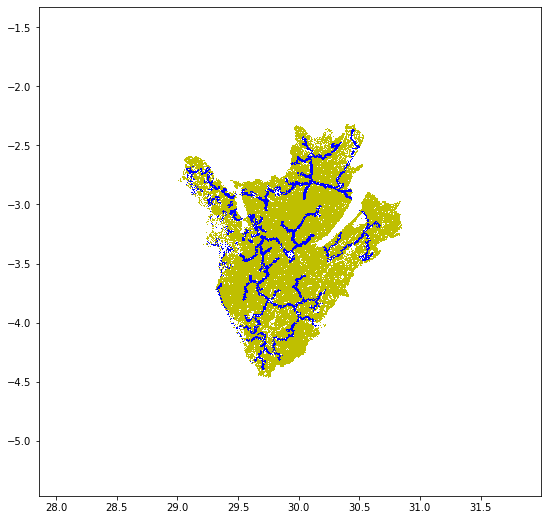

<Figure size 2160x2160 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_Y_DEG], 'y,')
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_Y_DEG], 'b,')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

# 6. Define the demand

This piece of code defines the target electricity demand in the region/country. Residential electricity demand is defined as kWh/household/year, while all other demands are defined as kWh/capita/year. Note that at the moment, all productive uses demands are set to 0 by default.

In [20]:
# Define the annual household electricity targets to choose from
tier_1 = 38.7  # 38.7 refers to kWh/household/year. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 2993

onsseter.prepare_wtf_tier_columns(num_people_per_hh_rural, num_people_per_hh_urban, tier_1, tier_2, tier_3, tier_4, tier_5)

In [21]:
onsseter.df[SET_EDU_DEMAND] = 0           # Demand for educational facilities (kWh/capita/year)
onsseter.df[SET_HEALTH_DEMAND] = 0        # Demand for health facilities (kWh/capita/year)
onsseter.df[SET_COMMERCIAL_DEMAND] = 0    # Demand for commercial activities (kWh/capita/year)
onsseter.df[SET_AGRI_DEMAND] = 0          # Demand for agricultural activities (kWh/capita/year)
productive_demand = 0 # 1 if productive demand is defined and should be included, else 0

# 7. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every off-grid technology can provide, for each single populated settlement of the selected country. The cell then takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more economical to connect them to the grid, or to use one of the off-grid technologies calculated above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

In [22]:
onsseter.current_mv_line_dist()

for year in yearsofanalysis:
    end_year_pop = 1
    prioritization = 2
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit[year] * 1000
    grid_connect_limit = time_step * annual_new_grid_connections_limit[year] * 1000
    
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step,
                                            start_year, urban_target_tier, 
                                            rural_target_tier)

    sa_diesel_investment, sa_pv_investment, mg_diesel_investment, mg_pv_investment, mg_wind_investment, \
                                        mg_hydro_investment = onsseter.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, mg_pv_calc,
                                                                                                sa_pv_calc, mg_diesel_calc,
                                                                                                sa_diesel_calc, year, end_year, time_step)
    
    grid_investment = np.zeros(len(onsseter.df['X_deg']))
    grid_investment, grid_cap_gen_limit, grid_connect_limit = \
                                        onsseter.pre_electrification(grid_generation_cost, year, time_step, end_year, grid_calc, grid_cap_gen_limit,
                                                                     grid_connect_limit, grid_investment)

    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
                                    onsseter.df[SET_ELEC_ORDER + "{}".format(year)], onsseter.df[SET_MV_CONNECT_DIST], grid_investment = \
                                        onsseter.elec_extension(grid_calc,
                                                                mv_line_max_length,
                                                                year,
                                                                start_year,
                                                                end_year,
                                                                time_step,
                                                                grid_cap_gen_limit,
                                                                grid_connect_limit,
                                                                auto_intensification=auto_intensification,
                                                                prioritization=prioritization,
                                                                new_investment=grid_investment)

    onsseter.results_columns(year, time_step, prioritization, auto_intensification, auto_intensification, auto_intensification)

    onsseter.calculate_investments(sa_diesel_investment, sa_pv_investment, mg_diesel_investment,
                                   mg_pv_investment, mg_wind_investment,
                                   mg_hydro_investment, grid_investment, year)

    onsseter.apply_limitations(eleclimit, year, time_step, prioritization, auto_intensification)

    onsseter.calculate_new_capacity(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                                                    sa_diesel_calc, grid_calc, grid_calc, grid_calc, year)    

Le taux d'électrification atteint en 2030 est 100.0 %


### New grid extension algorithm

In [23]:
filter_lcoe, filter_investment, peak_load = onsseter.get_grid_lcoe(0, 0, 0, year, time_step, end_year, grid_calc, get_max_dist=True)

In [24]:
project_life = year - start_year
years = np.arange(project_life)
step = (year - time_step) - start_year
prev_code = onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year-time_step)]
generation_per_year = np.where(((prev_code < 2) | (prev_code > 3)),
                                       onsseter.df[SET_ENERGY_PER_CELL + '{}'.format(year)],
                                       onsseter.df[SET_TOTAL_ENERGY_PER_CELL])

el_gen = np.outer(np.asarray(generation_per_year), np.ones(project_life))
for s in range(step):
    el_gen[:, s] = 0

discount_factor = (1 + discount_rate) ** years
discounted_generation = el_gen / discount_factor
discounted_generation = np.sum(discounted_generation, axis=1)

discounted_generation = pd.Series(discounted_generation)
#max_discounted_investments = filter_lcoe[0] * discounted_generation
max_discounted_investments = (onsseter.df['Minimum_LCOE_Off_grid{}'.format(year)] - filter_lcoe[0]) * discounted_generation
max_investment = max_discounted_investments * discount_factor[year - time_step - start_year]

In [25]:
mv_lv_sub_station_type=400
hv_lv_sub_station_type=1000
hv_to_mv_lines = hv_line_cost / mv_line_cost
max_mv_load = MV_line_amperage_limit * mv_line_capacity * hv_to_mv_lines
mv_amperage = mv_lv_sub_station_type / mv_line_capacity
no_of_mv_lines = np.ceil(peak_load / (mv_amperage * mv_line_capacity))
hv_amperage = hv_lv_sub_station_type / hv_line_capacity
no_of_hv_lines = np.ceil(peak_load / (hv_amperage * hv_line_capacity))

mv_lines = np.where((peak_load <= max_mv_load), no_of_mv_lines, 0)
hv_lines = np.where((peak_load <= max_mv_load), 0, no_of_hv_lines)
mv_cost_per_km = mv_lines * mv_line_cost
hv_cost_per_km = hv_lines * hv_line_cost
cost_per_km = mv_cost_per_km + hv_cost_per_km

# ToDo make sure HV line is used if max_dist > max_mv_dist
# ToDo make sure max_dist.min() is not <0
max_dist = max_investment / cost_per_km
onsseter.df['MaxDist'] = max_dist

#### Read cost and origins layer

In [26]:
raster = rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\raster.tif')
shape = raster.shape
affine = raster.transform

out_meta = raster.meta

out_meta.update({"driver": "GTiff",
                 "height": raster.height,
                 "width": raster.width,
                 "transform": raster.transform,
                 'compress': 'NONE',
                 'dtype': rasterio.float32,
                 "crs": raster.crs,
                 'nodata': 9999})

In [27]:
with rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\final_cost.tif') as cost:
    cost_val = cost.read(1) / 20
    cost_meta = cost.meta
    
with rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\power_cost.tif') as power:
    power_val = power.read(1)
    power_meta = power.meta

In [28]:
rows, cols = np.where(power_val == 0)
#Adding start values (origins)
start_list = []
i = 0
for row in rows:
    positions = [rows[i],cols[i]]
    start_list.append(positions)
    i = i+1

In [29]:
path = np.zeros_like(cost_val)

In [33]:
@numba.njit
def find_path(cost_val, search_dist, start_list, path):
    # Find minimum cost path betweenn all nodes
    mcp = MCP_Geometric(cost_val, fully_connected=True)
    
    # Identify the target locations to connect
    targets = onsseter.df.loc[(onsseter.df['ElecStart'] != 1) & (onsseter.df['MaxDist'] > 0) & (onsseter.df['PlannedHVLineDist'] > search_dist)]
    targets = targets.to_crs(3395)
    targets_for_raster = [(row.geometry, row.MaxDist) for _, row in targets.iterrows()]

    targets_raster = rasterize(
            targets_for_raster,
            out_shape=shape,
            fill=0,
            default_value=0,
            all_touched=True,
            transform=affine,
        )
    
    # Find cumulative cost raster
    cumulative_costs, traceback = mcp.find_costs(starts=start_list) 
    cumulative_costs[np.where(cumulative_costs==float('inf'))] = np.nan
    
    # Identify the locations which can be economically reached
    rows, cols = np.where((targets_raster > cumulative_costs) & (path == 0))
    filtered_end_list = np.column_stack((rows, cols)).tolist()
    
    # Identify the network to reach the economical locations
    for end in filtered_end_list:
        route = mcp.traceback(end)
        indices = np.array(route).T
        path[indices[0], indices[1]] = 1
        
    # Update origins with newly identified lines
    rows, cols = np.where(path == 1)
    pointlist = np.column_stack((rows, cols)).tolist()
    start_list = start_list + pointlist
    
    # Update the cost raster to set cost = 0 at new lines
    cost_val = np.where(path == 1, 0, cost_val)
    print(len(filtered_end_list))
    return cost_val, start_list, path, len(filtered_end_list)
    

In [30]:
for i in range(60):
    cost_val, start_list, path, new_targets = find_path(cost_val, 29.5 - i*0.5, start_list, path)

132
843
211
172
269
316
353
347
408
412
460
485
466
497
512
575
546
571
610
651
656
726
711
739
704
748
794
878
794
836
896
942
971
1054
1127
1208
1314
1440
1512
1469
1595
1683
1732
1717
1696
1730
1789
1909
2013
2054
2151
2252
2236
2377
2412
2353
2203
2206
108
7


In [31]:
i = 0
while new_targets > 0:
    cost_val, start_list, path, new_targets = find_path(cost_val, 9999, start_list, path)
    i += 1
    if i > 10:
        break

ValueError: No valid geometry objects found for rasterize

In [34]:
%lprun -u 0.001 -f find_path find_path(cost_val, 0, start_list, path)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'MCP_Geometric':[0m [1m[1mCannot determine Numba type of <class 'type'>[0m
[1m
File "..\..\Users\asahl\AppData\Local\Temp\ipykernel_1488\939653447.py", line 4:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [ ]:
targets.to_csv(r'C:\GitHub\many-to-many-dijkstra\burundi\actual_targets.csv')

In [32]:
with rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\path_actual_targets_5_inverse.tif', 'w', **cost_meta) as dst:
    dst.write(path, indexes=1)

In [ ]:

with rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\mcp.tif', 'w', **cost_meta) as dst:
    dst.write(cumulative_costs, indexes=1)
with rasterio.open(r'C:\GitHub\many-to-many-dijkstra\burundi\traceback.tif', 'w', **cost_meta) as dst:
    dst.write(traceback, indexes=1)

# 8. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [ ]:
elements = []
for year in yearsofanalysis:
    elements.append("Population{}".format(year))
    elements.append("NewConnections{}".format(year))
    elements.append("Capacity{}".format(year))
    elements.append("Investment{}".format(year))

techs = ["Grid", "SA_Diesel", "SA_PV", "MG_Diesel", "MG_PV", "MG_Wind", "MG_Hydro"]

sumtechs = []
for year in yearsofanalysis:
    sumtechs.extend(["Population{}".format(year) + t for t in techs])
    sumtechs.extend(["NewConnections{}".format(year) + t for t in techs])
    sumtechs.extend(["Capacity{}".format(year) + t for t in techs])
    sumtechs.extend(["Investment{}".format(year) + t for t in techs])

summary = pd.Series(index=sumtechs, name='country')

for year in yearsofanalysis:
    for t in techs:
        summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)), SET_POP + '{}'.format(year)].sum()
        summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
        summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
        summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
        
index = techs + ['Total']
columns = []
for year in yearsofanalysis:
    columns.append("Population{}".format(year))
    columns.append("NewConnections{}".format(year))
    columns.append("Capacity{} (MW)".format(year))
    columns.append("Investment{} (million USD)".format(year))
                                                                                                                                           
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table[columns[4]] = summary.iloc[28:35].astype(int).tolist() + [int(summary.iloc[28:35].sum())]
summary_table[columns[5]] = summary.iloc[35:42].astype(int).tolist() + [int(summary.iloc[35:42].sum())]
summary_table[columns[6]] = summary.iloc[42:49].astype(int).tolist() + [int(summary.iloc[42:49].sum())]
summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[49:56].astype(float).tolist()] + [round(summary.iloc[49:56].sum()/1e4)/1e2]

In [ ]:
display(Markdown('### Summary \n These are the summarized results for full electrification of the selected country by the final year'))
summary_table

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

In [ ]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#EDA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#EDD100', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#98E600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#70A800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#1FA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#73B2FF', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

## 9. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

Before we proceed, please write the scenario_name in the first cell below. then move on to the next cell and run it to browse to the directory where you want to save your results. Sample file shall be located at .\ gep-onsset\sample_output. 

**Note that if you do not change the scenario name, the previous output files will be overwritten**

In [ ]:
scenario_name = "scenario_name"

In [ ]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_target,'','',''),
         ('PV cost adjustment factor', pv_adjustment_factor, '', '', ''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Prioritization', prioritization,'','','1 = baseline, 2 = intensification'),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('coordinate_units',coordinate_units,'','','1000 if coordinates are in m, 1 if coordinates are in km'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2016)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2016)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2016)'),
         ('urban_elec_ratio',urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2016)'),
         ('rural_elec_ratio',rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2016)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',base_to_peak,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('sa_diesel_capital_cost',sa_diesel_capital_cost,'','','Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_diesel_capital_cost',mg_diesel_capital_cost,'','','Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_pv_capital_cost',mg_pv_capital_cost,'','','Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_wind_capital_cost',mg_wind_capital_cost,'','','Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_lv_transformer_cost',hv_lv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('mv_increase_rate',mv_increase_rate,'','','percentage'),
         ('max_grid_extension_dist',max_mv_line_dist,'','','Maximum distance that the grid may be extended by means of MV lines'),
         ('annual_new_grid_connections_limit', annual_new_grid_connections_limit,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit',annual_grid_cap_gen_limit,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         ('GIS data: Administrative boundaries','','','','Delineates the boundaries of the analysis.'),
         ('GIS data: DEM','','','','Filled DEM (elevation) maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Hydropower','','','','Points showing potential mini/small hydropower potential.  Provides power availability in each identified point.'),
         ('GIS data: Land Cover','','','','Land cover maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Night-time Lights','','','','Dataset used to,identify and spatially calibrate the currently electrified/non-electrified population.'),
         ('GIS data: Population','','','','Spatial identification and quantification of the current (base year) population. This dataset sets the basis of the ONSSET analysis as it is directly connected with the electricity demand and the assignment of energy access goals'),
         ('GIS data: Roads','','','','Current road infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Solar GHI','','','','Provide information about the Global Horizontal Irradiation (kWh/m2/year) over an area. This is later used to identify the availability/suitability of Photovoltaic systems.'),
         ('GIS data: Substations','','','','Current Substation infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Existing grid','','','','Current grid network'),
         ('GIS data: Planned grid','','','','Planned/committed grid network extensions'),
         ('GIS data: Travel-time','','','','Visualizes spatially the travel time required to reach from any individual cell to the closest town with population more than 50,000 people.'),
         ('GIS data: Wind velocity','','','','Provide information about the wind velocity (m/sec) over an area. This is later used to identify the availability/suitability of wind power (using Capacity factors).'),
        ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [ ]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [ ]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)